# Import Libraries

In [1]:
# Initial imports and enviroment setup
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

import os
sns.set()

if 'notebook' in os.getcwd():
    os.chdir('..')


# Environment setup
Here, we will solve a gridworld problem where we can control the terminal locations (where the game ends) and reward.

In [2]:
# create grid world invironment
from src.env.gridworld import GridworldEnv, Video_callback

In [3]:
# Here we define the grid world by defining the size and the location of rewards
simple_env = np.array([ [ -5,  0,  0,  0,  0, 10],
                        [  0,  0,  0,  0,  0,  0],
                        [  3,  0,  0, -5,  0,  0],
                        [-10,  0,  0,  0,  0,  0]])
rewards = simple_env.flatten()
terminal_states = [i for i, x in enumerate(rewards) if not (x == 0)] # Terminal states are any location where the reward is not 0

env = GridworldEnv(size = simple_env.shape, rewards = rewards, terminal_states = terminal_states)

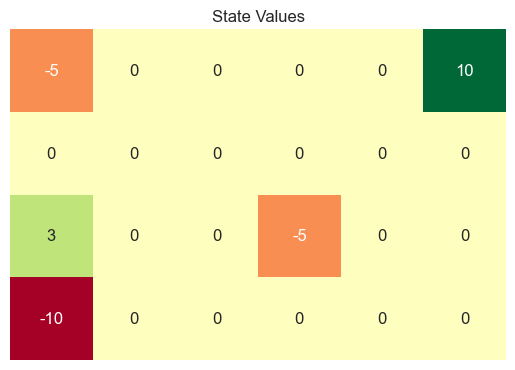

In [4]:
env.grid_print(env.rewards)

Behold, grid world!

# Value Iteration

## A single iteration of value updates
For each state, we update the values by checking how each action transitiona the model. For a given state, the value is updated as follows:
- For each action given the current state, add the current reward with the discounted reward for every new state it can transition.
- Compute the expected reward of the action.
- Compute the expected reward over all actions given the policy.

$$ V'(s) = \sum_{a} \pi(a|s) \sum_{s', r} Pr(s',r|s,a)(r(s) + \lambda V_{t}(s'))$$

where:
- $\pi$: Policy
- $V(s)$: Current value of a state
- $V'(s)$: New value of a state
- $Pr$: Probability function
- $s$: current state
- $s'$: next state after an action is taken
- $a$: action
- $\lambda$: discount factor


In [5]:
def update_values(env, V, discount_factor=1.0, verbose = 0, delta = 0, callback = None):
    V_new = np.copy(V)
    if verbose > 0:
        env.grid_print(V, k=0)
    if callback is not None:
        callback.write(np.copy(V_new))
    for s in range(env.nS):
        q = np.zeros(env.nA)
        # Look at the possible next actions
        for a in range(env.nA):
            # For each action, look at the possible next states
            # to calculate q[s,a]
            for prob, next_state, reward, done in env.P[s][a]:
                # Calculate the value for each action as per backup diagram
                if not done:
                    q[a] += prob*(reward + discount_factor * V[next_state])
                else:
                    q[a] += prob * reward

        # find the maximum value over all possible actions
        # and store updated state value
        V_new[s] = q.max()
        if verbose > 0:
            env.grid_print(V_new, k=s + 1)
        if callback is not None:
            callback.write(np.copy(V_new))
        # How much our value function changed (across any states)
        delta = max(delta, np.abs(V_new[s] - V[s]))
    return V_new, delta

## 1st Iteration of value updates

In [6]:
env.reset()
video_1 = Video_callback(env.shape, value_range = (rewards.min(), rewards.max()))

# Assume we know nothing about the rewards
V0 = np.zeros(env.nS)
V_new, delta = update_values(env, V0, discount_factor=0.5, verbose = 0, callback = video_1)
video_1.plot()

# 2nd Interation of vlaue updates

In [7]:
video_2 = Video_callback(env.shape, value_range = (rewards.min(), rewards.max()))
V_new, delta = update_values(env, V_new, discount_factor=0.5, verbose = 0, callback = video_2)
video_2.plot()

# Full value iteration algorithm

In [8]:
# Value Iteration
def value_iteration(env, discount_factor=1.0, theta=0.00001, verbose = 0,  callback = None):
    """
    Varry out Value iteration given an environment and a full description
    of the environment's dynamics.

    Args:
        env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        discount_factor: Gamma discount factor.
        theta: tolernace level to stop the iterations

    Returns:
        policy: [S, A] shaped matrix representing optimal policy.
        value : [S] length vector representing optimal value
    """

    def argmax_a(arr):
        """
        Return idx of max element in an array.
        """
        max_idx = []
        max_val = float('-inf')
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return max_idx

    optimal_policy = np.zeros([env.nS, env.nA])
    V = np.zeros(env.nS)
    V_new = np.copy(V)
    i = 0
    if verbose > 0:
        env.grid_print(V_new, k=i)
    if callback is not None:
        callback.write(np.copy(V_new))

    while True:
        i += 1
        delta = 0
        # For each state, perform a "greedy backup"
        V_new, delta = update_values(env, V, 
                                     discount_factor=1.0, 
                                     verbose = verbose - 1, 
                                     delta = delta)
        
        V = np.copy(V_new)
        if verbose > 0:
            env.grid_print(V_new, k=i)
        if callback is not None:
            callback.write(np.copy(V_new))

        # Stop if change is below a threshold
        if delta < theta:
            break

    # V(s) has optimal values. Use these values and one step backup
    # to calculate optimal policy
    for s in range(env.nS):
        q = np.zeros(env.nA)
        # Look at the possible next actions
        for a in range(env.nA):
            # For each action, look at the possible next states
            # and calculate q[s,a]
            for prob, next_state, reward, done in env.P[s][a]:

                # Calculate the value for each action as per backup diagram
                if not done:
                    q[a] += prob * (reward + discount_factor * V[next_state])
                else:
                    q[a] += prob * reward

        # find the optimal actions
        # We are returning stochastic policy which will assign equal
        # probability to all those actions which are equal to maximum value
        best_actions = argmax_a(q)
        optimal_policy[s, best_actions] = 1.0 / len(best_actions)

    return optimal_policy, V

In [9]:
video_full = Video_callback(env.shape, value_range = (rewards.min(), rewards.max()))
# Run policy iteration on Grid world
pi_star, V_star = value_iteration(env, verbose = 0, callback = video_full)

video_full.plot().show()

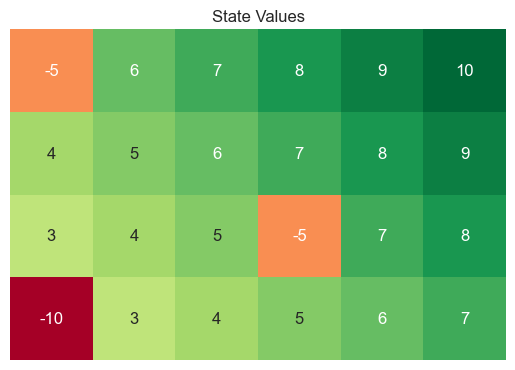

In [10]:
env.grid_print(V_star.reshape(env.shape))

In [11]:
# Print Optimal policy
print("Optimal Policy\n", pi_star)

Optimal Policy
 [[0.25 0.25 0.25 0.25]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   1.   0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.5  0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.5  0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.5  0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [1.   0.   0.   0.  ]]


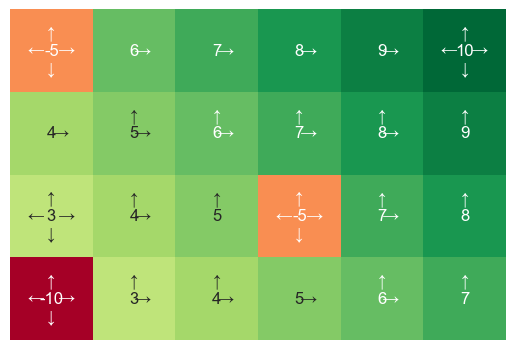

In [13]:
env.policy_print(V_star, pi_star)

# Policy Iteration

In [15]:
# Policy Iteration

def policy_evaluation(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and
    a full description of the environment's dynamics.

    Args:
        policy:[S, A] shaped matrix representing the policy. Random in our case
        env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        theta: Stop evaluation once value function change is
            less than theta for all states.
        discount_factor: Gamma discount factor.

    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a (all 0) value function
    V = np.zeros(env.nS)
    V_new = np.copy(V)
    while True:
        delta = 0
        # For each state, perform a "backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, pi_a in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value as per backup diagram
                    v += pi_a * prob * \
                        (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            V_new[s] = v
            delta = max(delta, np.abs(V_new[s] - V[s]))
        V = np.copy(V_new)
        # Stop if change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [16]:
# Policy Improvement

def policy_improvement(policy, V, env, discount_factor=1.0):
    """
    Improve a policy given an environment and a full description
    of the environment's dynamics and the state-values V.

    Args:
        policy: [S, A] shaped matrix representing the policy.
        V: current state-value for the given policy
        env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        discount_factor: Gamma discount factor.

    Returns:
        policy: [S, A] shaped matrix representing improved policy.
        policy_changed: boolean which has value of `True` if there
                        was a change in policy
    """

    def argmax_a(arr):
        """
        Return idxs of all max values in an array.
        """
        max_idx = []
        max_val = float('-inf')
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return max_idx

    policy_changed = False
    Q = np.zeros([env.nS, env.nA])
    new_policy = np.zeros([env.nS, env.nA])

    # For each state, perform a "greedy improvement"
    for s in range(env.nS):
        old_action = np.array(policy[s])
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[s][a]:
                # Calculate the expected value as per backup diagram
                Q[s, a] += prob * (reward + discount_factor * V[next_state])

        # get maximizing actions and set new policy for state s
        best_actions = argmax_a(Q[s])
        new_policy[s, best_actions] = 1.0 / len(best_actions)

    if not np.allclose(new_policy[s], policy[s]):
        policy_changed = True

    return new_policy, policy_changed

In [17]:
# Policy Iteration

def policy_iteration(env, discount_factor=1.0, theta=0.00001):

    # initialize a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        V = policy_evaluation(policy, env, discount_factor, theta)
        policy, changed = policy_improvement(policy, V, env, discount_factor)
        if not changed:  # terminate iteration once no improvement is observed
            V_optimal = policy_evaluation(policy, env, discount_factor, theta)
            print("Optimal Policy\n", policy)
            return np.array(V_optimal)

In [18]:
env.reset()

12

In [19]:
# Run policy iteration on Grid world
V_star = policy_iteration(env)

# Print optimal policy state values
env.grid_print(V_star.reshape(env.shape))

In [ ]:
# Summary